device and dtype setup

In [1]:
import os
import torch


tkwargs = {
    "dtype": torch.double,
    "device": torch.device("cuda" if torch.cuda.is_available() else "cpu"),
}
SMOKE_TEST = os.environ.get("SMOKE_TEST")

problem setup

In [2]:
from botorch.test_functions.multi_objective import BraninCurrin


problem = BraninCurrin(negate=True).to(**tkwargs)

/home/wzhmiasanmia/miniconda3/envs/maenv/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


model initialization

In [3]:
from botorch.models.gp_regression import FixedNoiseGP
from botorch.models.model_list_gp_regression import ModelListGP
from botorch.models.transforms.outcome import Standardize
from gpytorch.mlls.sum_marginal_log_likelihood import SumMarginalLogLikelihood
from botorch.utils.transforms import unnormalize, normalize
from botorch.utils.sampling import draw_sobol_samples

NOISE_SE = torch.tensor([15.19, 0.63], **tkwargs)


def generate_initial_data(n=6):
    # generate training data
    train_x = draw_sobol_samples(bounds=problem.bounds, n=n, q=1).squeeze(1)
    train_obj_true = problem(train_x)
    train_obj = train_obj_true + torch.randn_like(train_obj_true) * NOISE_SE
    return train_x, train_obj, train_obj_true


def initialize_model(train_x, train_obj):
    # define models for objective and constraint
    train_x = normalize(train_x, problem.bounds)
    models = []
    for i in range(train_obj.shape[-1]):
        train_y = train_obj[..., i : i + 1]
        train_yvar = torch.full_like(train_y, NOISE_SE[i] ** 2)
        models.append(
            FixedNoiseGP(
                train_x, train_y, train_yvar, outcome_transform=Standardize(m=1)
            )
        )
    model = ModelListGP(*models)
    mll = SumMarginalLogLikelihood(model.likelihood, model)
    return mll, model

Define a helper functions that performs the essential BO step for $q$EHVI

In [4]:
from botorch.optim.optimize import optimize_acqf, optimize_acqf_list
from botorch.acquisition.objective import GenericMCObjective
from botorch.utils.multi_objective.scalarization import get_chebyshev_scalarization
from botorch.utils.multi_objective.box_decompositions.non_dominated import (
    FastNondominatedPartitioning,
)
from botorch.acquisition.multi_objective.monte_carlo import (
    qExpectedHypervolumeImprovement,
    qNoisyExpectedHypervolumeImprovement,
)
from botorch.utils.sampling import sample_simplex


BATCH_SIZE = 4
NUM_RESTARTS = 10 if not SMOKE_TEST else 2
RAW_SAMPLES = 512 if not SMOKE_TEST else 4

standard_bounds = torch.zeros(2, problem.dim, **tkwargs)
standard_bounds[1] = 1


def optimize_qehvi_and_get_observation(model, train_x, train_obj, sampler):
    """Optimizes the qEHVI acquisition function, and returns a new candidate and observation."""
    # partition non-dominated space into disjoint rectangles
    with torch.no_grad():
        pred = model.posterior(normalize(train_x, problem.bounds)).mean
    partitioning = FastNondominatedPartitioning(
        ref_point=problem.ref_point,
        Y=pred,
    )
    acq_func = qExpectedHypervolumeImprovement(
        model=model,
        ref_point=problem.ref_point,
        partitioning=partitioning,
        sampler=sampler,
    )
    # optimize
    candidates, _ = optimize_acqf(
        acq_function=acq_func,
        bounds=standard_bounds,
        q=BATCH_SIZE,
        num_restarts=NUM_RESTARTS,
        raw_samples=RAW_SAMPLES,  # used for intialization heuristic
        options={"batch_limit": 5, "maxiter": 200},
        sequential=True,
    )
    # observe new values
    new_x = unnormalize(candidates.detach(), bounds=problem.bounds)
    new_obj_true = problem(new_x)
    new_obj = new_obj_true + torch.randn_like(new_obj_true) * NOISE_SE
    return new_x, new_obj, new_obj_true

perform Bayesian Optimization loop with $q$EHVI

In [5]:
import time
import warnings
from botorch import fit_gpytorch_mll
from botorch.exceptions import BadInitialCandidatesWarning
from botorch.sampling.normal import SobolQMCNormalSampler
from botorch.utils.multi_objective.box_decompositions.dominated import (
    DominatedPartitioning,
)

warnings.filterwarnings("ignore", category=BadInitialCandidatesWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)

N_BATCH = 20 if not SMOKE_TEST else 10
MC_SAMPLES = 128 if not SMOKE_TEST else 16

verbose = True

hvs_qehvi = []

# call helper functions to generate initial training data and initialize model
train_x_qehvi, train_obj_qehvi, train_obj_true_qehvi = generate_initial_data(
    n=2 * (problem.dim + 1)
)
mll_qehvi, model_qehvi = initialize_model(train_x_qehvi, train_obj_qehvi)

# compute hypervolume
bd = DominatedPartitioning(ref_point=problem.ref_point, Y=train_obj_true_qehvi)
volume = bd.compute_hypervolume().item()

hvs_qehvi.append(volume)

# run N_BATCH rounds of BayesOpt after the initial random batch
for iteration in range(1, N_BATCH + 1):
    t0 = time.monotonic()

    # fit the model
    fit_gpytorch_mll(mll_qehvi)

    # define the qEHVI acquisition module using a QMC sampler
    qehvi_sampler = SobolQMCNormalSampler(sample_shape=torch.Size([MC_SAMPLES]))

    # optimize acquisition function and get new observations
    new_x_qehvi, new_obj_qehvi, new_obj_true_qehvi = optimize_qehvi_and_get_observation(
        model_qehvi, train_x_qehvi, train_obj_qehvi, qehvi_sampler
    )

    # update training points
    train_x_qehvi = torch.cat([train_x_qehvi, new_x_qehvi])
    train_obj_qehvi = torch.cat([train_obj_qehvi, new_obj_qehvi])
    train_obj_true_qehvi = torch.cat([train_obj_true_qehvi, new_obj_true_qehvi])

    # update progress
    bd = DominatedPartitioning(ref_point=problem.ref_point, Y=train_obj_true_qehvi)
    volume = bd.compute_hypervolume().item()
    hvs_qehvi.append(volume)

    # reinitialize the model for the next iteration
    mll_qehvi, model_qehvi = initialize_model(train_x_qehvi, train_obj_qehvi)

    t1 = time.monotonic()

    if verbose:
        print(
            f"\nBatch {iteration:>2}: Hypervolume (qEHVI) = {hvs_qehvi[-1]:>4.2f}, time = {t1-t0:>4.2f}.",
            end="",
        )
    else:
        print(".", end="")



Batch  1: Hypervolume (qEHVI) = 2.37, time = 10.07.
Batch  2: Hypervolume (qEHVI) = 29.75, time = 8.24.
Batch  3: Hypervolume (qEHVI) = 32.17, time = 9.99.
Batch  4: Hypervolume (qEHVI) = 40.82, time = 11.55.
Batch  5: Hypervolume (qEHVI) = 46.26, time = 14.60.
Batch  6: Hypervolume (qEHVI) = 46.58, time = 12.11.
Batch  7: Hypervolume (qEHVI) = 48.22, time = 10.39.
Batch  8: Hypervolume (qEHVI) = 49.69, time = 13.99.
Batch  9: Hypervolume (qEHVI) = 49.73, time = 15.33.
Batch 10: Hypervolume (qEHVI) = 53.57, time = 16.16.
Batch 11: Hypervolume (qEHVI) = 55.32, time = 11.57.
Batch 12: Hypervolume (qEHVI) = 55.51, time = 15.63.
Batch 13: Hypervolume (qEHVI) = 56.05, time = 18.50.
Batch 14: Hypervolume (qEHVI) = 56.05, time = 13.68.
Batch 15: Hypervolume (qEHVI) = 56.08, time = 13.10.
Batch 16: Hypervolume (qEHVI) = 56.08, time = 17.22.
Batch 17: Hypervolume (qEHVI) = 56.33, time = 14.45.
Batch 18: Hypervolume (qEHVI) = 56.46, time = 21.29.
Batch 19: Hypervolume (qEHVI) = 56.46, time = 22

plot result curve

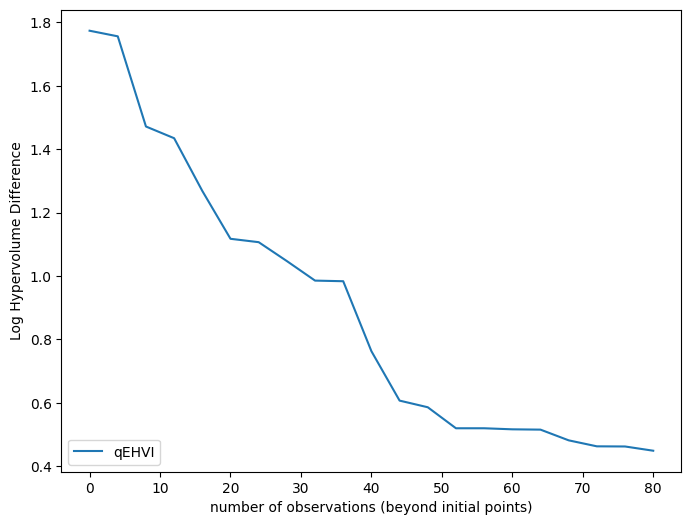

In [6]:
import numpy as np
from matplotlib import pyplot as plt

%matplotlib inline

iters = np.arange(N_BATCH + 1) * BATCH_SIZE
log_hv_difference_qehvi = np.log10(problem.max_hv - np.asarray(hvs_qehvi))

fig, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.errorbar(
    iters,
    log_hv_difference_qehvi,
    label="qEHVI",
    linewidth=1.5,
)
ax.set(
    xlabel="number of observations (beyond initial points)",
    ylabel="Log Hypervolume Difference",
)
ax.legend(loc="lower left")


plot true objectives 

/tmp/ipykernel_2193/4011355141.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cm = plt.cm.get_cmap("viridis")


Text(0.5, 1.0, 'Iteration')

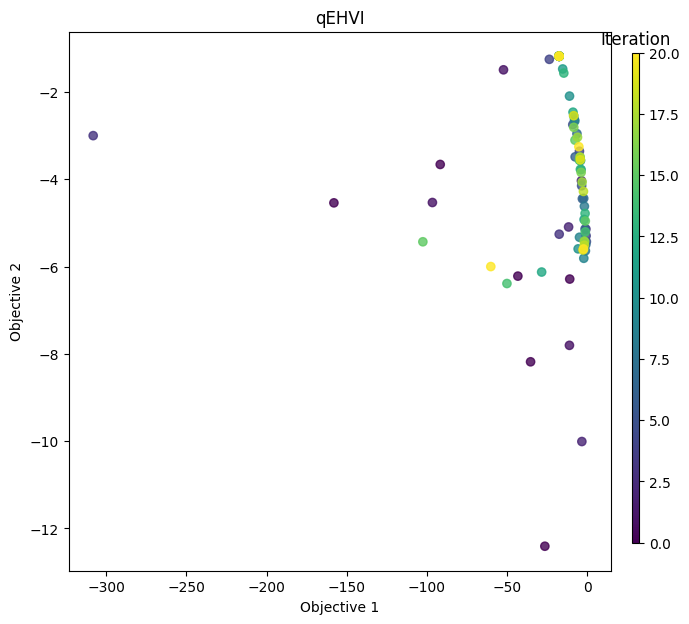

: 

In [7]:
from matplotlib.cm import ScalarMappable

fig, axes = plt.subplots(1, 1, figsize=(7, 7), sharex=True, sharey=True)
algos = ["qEHVI"]
cm = plt.cm.get_cmap("viridis")

batch_number = torch.cat(
    [
        torch.zeros(2 * (problem.dim + 1)),
        torch.arange(1, N_BATCH + 1).repeat(BATCH_SIZE, 1).t().reshape(-1),
    ]
).numpy()

sc = axes.scatter(
    train_obj_true_qehvi[:, 0].cpu().numpy(),
    train_obj_true_qehvi[:, 1].cpu().numpy(),
    c=batch_number,
    alpha=0.8,
)
axes.set_title(algos[0])
axes.set_xlabel("Objective 1")
axes.set_ylabel("Objective 2")

norm = plt.Normalize(batch_number.min(), batch_number.max())
sm = ScalarMappable(norm=norm, cmap=cm)
sm.set_array([])
fig.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.93, 0.15, 0.01, 0.7])
cbar = fig.colorbar(sm, cax=cbar_ax)
cbar.ax.set_title("Iteration")
